# Database
The following notebook build a sqlite database of approximately 9,000 earthquakes and ~200 countries. This db is later used to create 5 visualisations.

The table **countries** has the following columns:

1. Country Code
2. Country Name
3. Total Population (millions) ^
4. Human Developmnet Index ^

The table **earthquakes** was built using a GeoJSON file with information of every earthquake in the past 30 days. This dataset belongs to the United States Geological Survey (USGS)^^ and includes the following columns:
1. USGS Earthquake ID
2. Longitude
3. Latitude
4. Depth
5. Timestamp
6. Magnitude
7. Country Code

^ *Total Population* and *Human Development Index (HDI)* are values obtained from the *Human Development Report Office (HDRO)* (http://ec2-54-174-131-205.compute-1.amazonaws.com/API/Login.php). The HDRO offers an API for developers to query human development related data in JSON format. This dta is updated annually, upong the publication of the *global Human Development Report*

^^ USGS - GeoJSON Summary Format: https://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

Human development classification
HDI classifications are based on HDI fixed cutoff points, which are derived from the quartiles of dis
tributions of the component indicators. The cutoffpoints are HDI of less than 0.550 for low human development,
0.550–0.699 for medium human development, 0.700–0.799 for high human development and 0.800 or greater 
for very high human development.
Codes:
44206 - Total Population (millions)
137506 Human Development Index (HDI)

## Part 1: Importing/requesting data
Requesting json/geojson files from the HDRO and USGS.

In [67]:
import requests
from pprintpp import pprint as pp
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Defining years and indicators to retrieve from the HDRO

In [2]:
# HDRO Indicators
indicatorsHDRO = {
    "184306": "Number of deaths and missing persons attributed to disasters (per 100,000 population)",
    "44206": "Total population (millions)",
    "149406": "Homeless people due to natural disaster (average annual per million people)",
    "194906": "GDP per capita (2017 PPP $)"
}

In [3]:
urlHDRO = f"http://ec2-54-174-131-205.compute-1.amazonaws.com/API/HDRO_API.php/indicator_id=184306,44206,149406,194906/year=2011"
response_HDRO = requests.get(urlHDRO)
print(f"HDRO: {response_HDRO}")
jsonHDRO = response_HDRO.json()
# pp(jsonHDRO)

HDRO: <Response [200]>


Corroborating index 149406 (Homeless people due to natural disaster (average annual per million people)) is empty.

In [4]:
urlHDRO = f"http://ec2-54-174-131-205.compute-1.amazonaws.com/API/HDRO_API.php/indicator_id=149406/year=2011"
response_HDRO = requests.get(urlHDRO)
print(f"HDRO: {response_HDRO}")
homelessJSON = response_HDRO.json()
pp(homelessJSON)

HDRO: <Response [200]>
[]


Extracting all earthquakes with magnitude higher than 5 (Intesity of VI) from 2010 to 2020

In [5]:
# Earthquakes > 5 from 2010 to 2020
url_2010_2020_USGS = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2010-01-01%2000:00:00&endtime=2020-12-31%2023:59:59&minmagnitude=5&orderby=time-asc"
response_USGS = requests.get(url_2010_2020_USGS)
print(f"USGS: {response_USGS}")
jsonUSGS2010_2020 = response_USGS.json()


USGS: <Response [200]>


In [6]:
# pp(jsonUSGS2010_2020)

Build barchart

In [60]:
earthquakes_row = []

for earthquake in jsonUSGS2010_2020["features"]:
    ts = earthquake["properties"]["time"]
    mag = earthquake["properties"]["mag"]
    dt = datetime.utcfromtimestamp(int(ts)/1000)
    # print(dt)
    # print(dt.strftime("%Y-%m-%d %H:%M:%S"))
    earthquakes_row.append([dt.strftime("%Y"), mag])

dfEarthquakes = pd.DataFrame(earthquakes_row, columns = ["DATE", "MAGNITUDE"])
dfEarthquakes
    

,DATE,MAGNITUDE
0,2010,5.0
1,2010,5.2
2,2010,5.0
3,2010,5.0
4,2010,5.2
...,...,...
19776,2020,5.7
19777,2020,5.0
19778,2020,5.0
19779,2020,5.1


In [63]:
dfEarthquakesByYear = dfEarthquakes.groupby(["DATE"]).count()
dfEarthquakesByYear

,MAGNITUDE
DATE,
2010,2395
2011,2694
2012,1679
2013,1598
2014,1736
2015,1558
2016,1696
2017,1557
2018,1806


Text(0, 0.5, 'EARTHQUAKES PER YEAR')

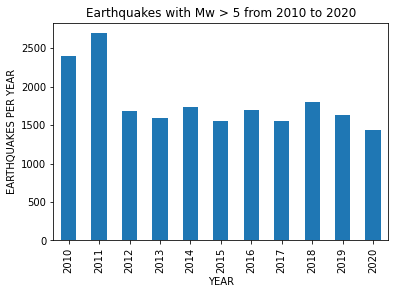

In [77]:
ax = dfEarthquakesByYear.plot(kind="bar", legend=False, title="Earthquakes with Mw > 5 from 2010 to 2020")
ax.set_xlabel("YEAR")
ax.set_ylabel("EARTHQUAKES PER YEAR")

NOTE: Plot all earthquakes magnitude >5 (2694 earthquakes) but only analyze earthquakes >6 (207 earthquakes)

In [ ]:
# All earthquakes in 2011
url_2011USGS = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2011-01-01%2000:00:00&endtime=2011-12-31%2023:59:59&minmagnitude=5&orderby=time"
response_USGS = requests.get(url_2011USGS)
print(f"USGS: {response_USGS}")
jsonUSGS = response_USGS.json()
pp(jsonUSGS)

The table *countries* required the country code in 2-digits-alpha format, but raw data was provided in 3-digit-alpha format. The repository https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes includes a ready-to-use csv file with both, 2- and 3-digit country codes. This table was used to convert between the 2 formats.

Reading the csv file with country code information. 

In [ ]:
import pandas as pd

countryCodes_df = pd.read_csv("../../data/all.csv")

## Part 2: Cleaning the data
**Actions taken to clean the csv file:**
1. The only columns needed are *Country name*, *country code in 2-digit format*, and *country code in 3-digit format*.
2. The 2-digit alpha code for country Namibia was missing, so the value was written manually.

In [ ]:
# countryCodes_df
clean_cc_df = countryCodes_df.copy()[["name", "alpha-2", "alpha-3"]]
clean_cc_df['alpha-2'][153] = 'NA'
clean_cc_df['alpha-2'][153]

In [ ]:
clean_cc_df.to_csv("./output_data/clean_cc_df.csv")

Understanding the structure of the HDRO json file:

In [ ]:
df_HDRO = pd.read_json(url_HDRO)
df_HDRO = df_HDRO.reset_index()
df_HDRO

Extracting the required values from the HDRO json file and saving them in a pandas dataframe using the try/except methods.

A few number of countries couldn't be saved into the dataframe as some of the required values were missing (see print outputs).

In [ ]:
clean_HDRO_df = pd.DataFrame(columns=['CountryName', 'CountryCode', 'HDI', "TotalPopulation"]) 
# clean_HDRO_df
for index, country in df_HDRO.iterrows():
    try:
        value_totalPopulation = float(country["indicator_value"]['44206']['2019'])
        value_HDI = float(country["indicator_value"]['137506']['2019'])
        clean_HDRO_df = clean_HDRO_df.append([{"CountryName": country["country_name"], "CountryCode": country["index"], "HDI": value_HDI, "TotalPopulation": value_totalPopulation}], ignore_index=True)
    except:
        print(country["index"], country["indicator_value"])

clean_HDRO_df


In [ ]:
clean_HDRO_df.to_csv("./output_data/clean_HDRO_df.csv")

The df *countries* and the df *country codes* were merged through the 3-digit country code columns:

In [ ]:
clean_HDRO_df = clean_HDRO_df.merge(clean_cc_df, left_on="CountryCode", right_on="alpha-3", how="inner")
clean_HDRO_df =clean_HDRO_df.drop(["CountryCode"], axis=1)


**Final HDRO table**

In [ ]:
clean_HDRO_df

In [ ]:
clean_HDRO_df.to_csv("./output_data/clean_HDRO_df_MERGED.csv")

## Part 3: SQL database

Importing required SQL Alchemy modules:

In [ ]:
# Import SQL Alchemy
from sqlalchemy import create_engine

# Import module to create relationship patterns
from sqlalchemy.orm import relationship

# Import and establish Base for which classes will be constructed
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

# Import modules to declare columns and column data types
from sqlalchemy import Table, Column, Integer, String, Float, BigInteger, ForeignKey

Creating *Countries* and *Earthquakes* classes:

In [ ]:
# Create classes:
# Countries & Earthquakes

class Countries(Base):  #Parent
    __tablename__ = 'countries'
    # id = Column(Integer, primary_key=True)
    CountryCode = Column(String(255), primary_key=True)
    CountryName = Column(String(255))
    Population = Column(Float)  # Millions
    HDIndex = Column(Float) # Index
    earthquake = relationship("Earthquakes")

class Earthquakes(Base):    #Child
    __tablename__ = 'earthquakes'
    # id = Column(Integer, primary_key=True)
    EarthquakeID = Column(String(255), primary_key=True)
    Latitude = Column(Float)
    Longitude = Column(Float)
    Depth = Column(Float)
    DateTime = Column(BigInteger)
    Magnitude = Column(Float)
    # CountryCode = Column(String(255))   # Foreign Key?
    country_id = Column(String(255), ForeignKey('countries.CountryCode'))
    # parent = relationship("Countries", back_populates="children")


# print(data_USGS["features"])

Since the GeoJson file doesn't provide the country name where each earthquake hit, reverse geocoding was implemented using the python library **reverse_geocoder** (https://github.com/thampiman/reverse-geocoder).

The library **tqdm** provides a nice and ready-to-use progress bar.

In [ ]:
import reverse_geocoder as rg
from time import sleep
from tqdm.auto import tqdm

The next block of code execute the following actions:
1. Creating Database Connection
2. Establishing connection to a sqlite database
3. Creating countries and Earthquakes tables

In [ ]:
# Create Database Connection
# ---------------------------
# Establish Connection
engine = create_engine("sqlite:///project2_test.sqlite")
conn = engine.connect()

# Create Countries and Earthquakes tables within the database
Base.metadata.create_all(conn)

# To push the objects made and query the server we use a Session object
from sqlalchemy.orm import Session
session = Session(bind=engine)

Inserting entries to the Country table.

In [ ]:
for index, country in tqdm(clean_HDRO_df.iterrows(), total=len(clean_HDRO_df)):
    # sleep(0.1)
    try:
        # Add new_country to the current session
        new_country = Countries(CountryCode=country["alpha-2"],CountryName=country["CountryName"],Population=country["TotalPopulation"],HDIndex=country["HDI"])
        session.add(new_country)

        # Commit objects to the database
        session.commit()
    except:
        print(country["alpha-2"], country["CountryName"], country["TotalPopulation"], country["HDI"])


Inserting entries to the Earthquake table (Reverse geocoding is used here) and after completion closing the connection to the sqlite database.

In [ ]:
cont=1
# Create specific instances of the Countries and Earthquakes classes
for earthquake in tqdm(data_USGS["features"], total=len(data_USGS["features"])):
    # sleep(0.1)

    if cont<=10:
        try:
            lon = earthquake["geometry"]["coordinates"][0]
            lat = earthquake["geometry"]["coordinates"][1]
            depth1 = earthquake["geometry"]["coordinates"][2]
            mag = earthquake["properties"]["mag"]
            datetime1 = earthquake["properties"]["time"]
            ctry_code = rg.search((lat,lon))[0]["cc"]
            new_earthquake = Earthquakes(EarthquakeID=earthquake["id"], Longitude=lon, Latitude=lat, Depth=depth1, DateTime=datetime1, Magnitude=mag, country_id=ctry_code)

            # Add new_earthquake to the current session
            session.add(new_earthquake)

            # Commit objects to the database
            session.commit()
            
        except:
            print(f"{earthquake['id']}, {lon}, {lat}, {depth1}, {earthquake['properties']['time']}, {ctry_code}")
        
        cont += 1
    else:
        break


conn.close()
engine.dispose()

In [ ]:
print("DATABASE COMPLETED")